In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
print(f"PyTorch Version: {torch.__version__}")
print(f"Torchvision Version: {torchvision.__version__}")

torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PyTorch Version: 2.3.0+cu118
Torchvision Version: 0.18.0+cu118
Using device: cuda


### Generative Adversarial Networks (GANs)
<p>GANs are a class of generative models that learn to generate new data with the same statistics as the training set.</p>
<p>Core Idea: Two neural networks, a Generator (G) and a Discriminator (D), are trained simulataneously in a "game-like" (adversarial) setting</p>

In [2]:
# Hyperparameters
img_channels = 1
img_size = 28
flattened_dim = img_size * img_size
latent_dim = 100
batch_size = 128
lr = 0.0002 
beta1 = 0.5
num_epochs = 50

In [4]:
transform_gan = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))   # Normalizes [0,1] to [-1,1]
])

In [5]:
train_dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform_gan)

In [6]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [7]:
len(train_dataset), train_dataset[0][0].shape

(60000, torch.Size([1, 28, 28]))

In [21]:
def imshow_gan(tensor_img_batch, title=None, num_images=16, unnormalize=True, nrow=4):
    if not isinstance(tensor_img_batch, torch.Tensor):
        raise TypeError(f"Expected tensor_img_batch to be a torch.Tensor, but got {type(tensor_img_batch)}")

    tensor_img_batch_processed = tensor_img_batch[:num_images].cpu().detach()
    
    if unnormalize:
        tensor_img_batch_processed = tensor_img_batch_processed * 0.5 + 0.5 
    
    grid_img = torchvision.utils.make_grid(tensor_img_batch_processed, nrow=nrow, padding=2, normalize=False)
    plt.figure(figsize=(nrow*1.5, (num_images // nrow)*1.5 if num_images > nrow else 2.0)) 
    plt.imshow(grid_img.permute(1, 2, 0).squeeze(), cmap='gray')
    if title: plt.title(title)
    plt.axis('off')
    plt.show()

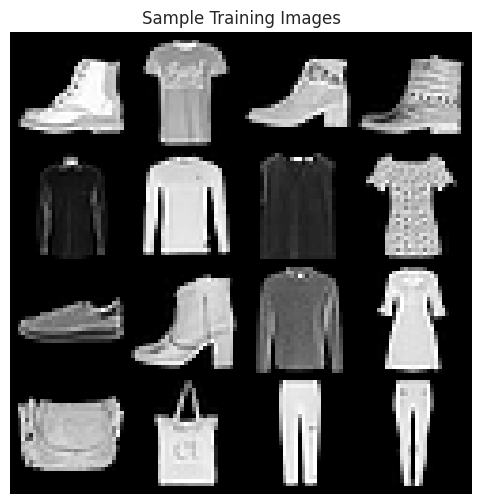

In [22]:
dataiter = iter(train_loader)
images_batch, _ = next(dataiter)
imshow_gan(images_batch, title="Sample Training Images", num_images=16, unnormalize=True)

### GAN Architecture 
A DCGAN (Deep Convolution GAN) would use convolutional layers and typically perform better for images.

In [24]:
# Generator Network (G)
# Takes random noise z (from latent_dim) and outputs a fake image (flattened_dim).
class GeneratorMLP(nn.Module):
    
    def __init__(self, latent_dim, img_flat_dim, hidden_dim1=256, hidden_dim2=512):
        super(GeneratorMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim1),
            nn.LeakyReLU(0.2, inplace=True), # LeakyReLU often used in GANs
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim2, img_flat_dim),
            nn.Tanh() # Output in [-1, 1] to match normalized image data
        )
        self.img_shape = (img_channels, img_size, img_size)

    def forward(self, z_noise):
        # z_noise: [batch_size, latent_dim]
        img_flat = self.model(z_noise)
        # Reshape flat output to image dimensions [batch_size, C, H, W]
        img_reshaped = img_flat.view(img_flat.size(0), *self.img_shape)
        return img_reshaped

In [25]:
# Discriminator Network (D)
# Takes an image (flattened) and outputs a scalar probability (0 for fake, 1 for real).
class DiscriminatorMLP(nn.Module):
    def __init__(self, img_flat_dim, hidden_dim1=512, hidden_dim2=256):
        super(DiscriminatorMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_flat_dim, hidden_dim1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3), # Dropout can help Discriminator generalize
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim2, 1) 
        )

    def forward(self, img_flat):
        # img_flat: [batch_size, img_flat_dim]
        validity_logit = self.model(img_flat)
        return validity_logit 

In [28]:
generator = GeneratorMLP(latent_dim, flattened_dim).to(device)
discriminator = DiscriminatorMLP(flattened_dim).to(device)

In [29]:
generator

GeneratorMLP(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Tanh()
  )
)

In [30]:
discriminator

DiscriminatorMLP(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [31]:
# test with dummy noise for generator
dummy_noise = torch.randn(batch_size, latent_dim).to(device)
with torch.no_grad():
    dummy_fake_imgs = generator(dummy_noise)
dummy_fake_imgs.shape

torch.Size([128, 1, 28, 28])

In [32]:
# test discriminator
with torch.no_grad():
    dummy_validity = discriminator(dummy_fake_imgs.view(batch_size, -1))
dummy_validity.shape

torch.Size([128, 1])

In [33]:
# Loss function and optimizer
adversarial_loss = nn.BCEWithLogitsLoss()

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

Epoch [1/50], D_Loss: 0.6821, G_Loss: 1.7630
Epoch [2/50], D_Loss: 0.6216, G_Loss: 2.5390
Epoch [3/50], D_Loss: 0.7315, G_Loss: 2.1632
Epoch [4/50], D_Loss: 0.8306, G_Loss: 1.9136
Epoch [5/50], D_Loss: 0.8931, G_Loss: 1.8128


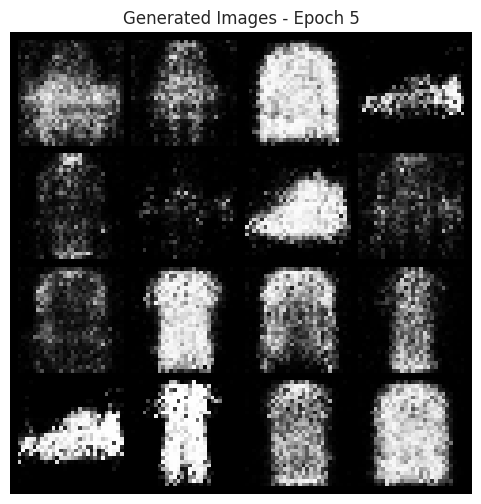

Epoch [6/50], D_Loss: 0.8838, G_Loss: 1.7789
Epoch [7/50], D_Loss: 0.9081, G_Loss: 1.7693
Epoch [8/50], D_Loss: 0.9421, G_Loss: 1.6591
Epoch [9/50], D_Loss: 0.9531, G_Loss: 1.5926
Epoch [10/50], D_Loss: 0.9657, G_Loss: 1.5531


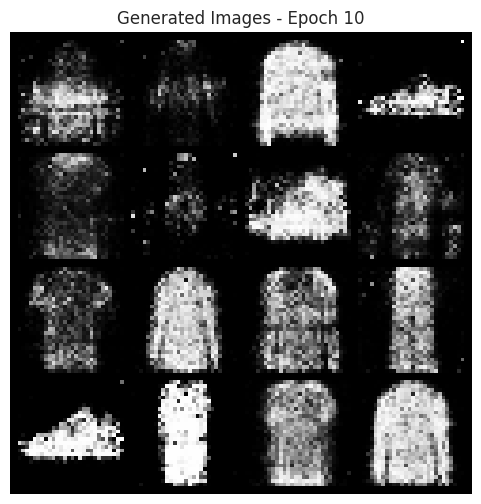

Epoch [11/50], D_Loss: 0.9920, G_Loss: 1.4986
Epoch [12/50], D_Loss: 1.0212, G_Loss: 1.4144
Epoch [13/50], D_Loss: 1.0240, G_Loss: 1.3947
Epoch [14/50], D_Loss: 1.0483, G_Loss: 1.3610
Epoch [15/50], D_Loss: 1.0587, G_Loss: 1.3206


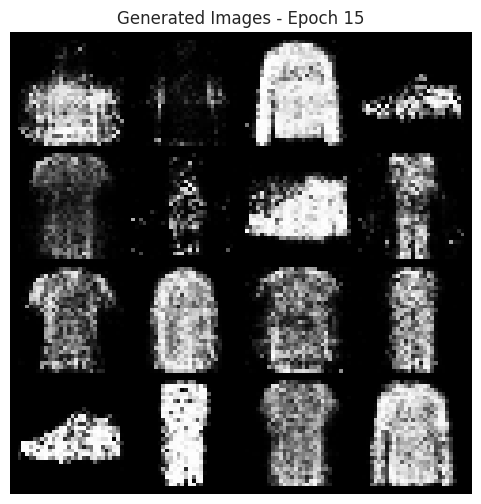

Epoch [16/50], D_Loss: 1.0705, G_Loss: 1.3133
Epoch [17/50], D_Loss: 1.0842, G_Loss: 1.2781
Epoch [18/50], D_Loss: 1.0863, G_Loss: 1.2623
Epoch [19/50], D_Loss: 1.0954, G_Loss: 1.2440
Epoch [20/50], D_Loss: 1.1132, G_Loss: 1.2219


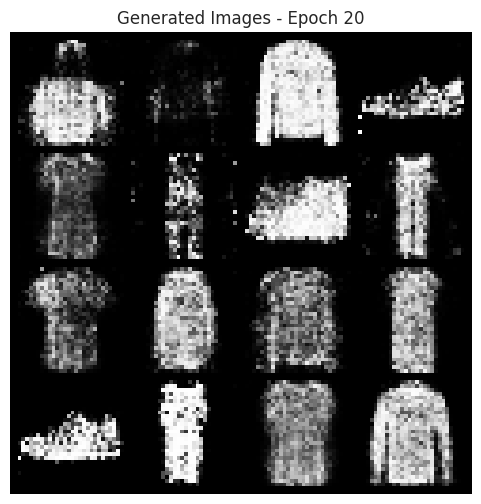

Epoch [21/50], D_Loss: 1.1189, G_Loss: 1.2073
Epoch [22/50], D_Loss: 1.1190, G_Loss: 1.1996
Epoch [23/50], D_Loss: 1.1305, G_Loss: 1.1846
Epoch [24/50], D_Loss: 1.1403, G_Loss: 1.1619
Epoch [25/50], D_Loss: 1.1492, G_Loss: 1.1523


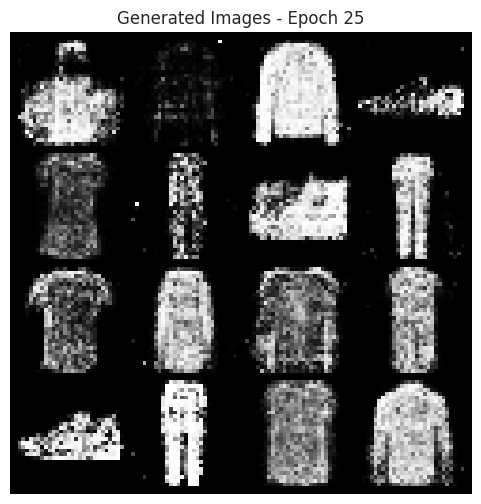

Epoch [26/50], D_Loss: 1.1519, G_Loss: 1.1488
Epoch [27/50], D_Loss: 1.1587, G_Loss: 1.1350
Epoch [28/50], D_Loss: 1.1601, G_Loss: 1.1257
Epoch [29/50], D_Loss: 1.1596, G_Loss: 1.1358
Epoch [30/50], D_Loss: 1.1677, G_Loss: 1.1242


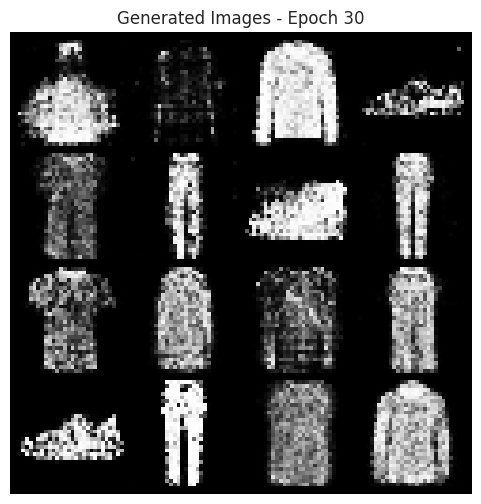

Epoch [31/50], D_Loss: 1.1635, G_Loss: 1.1210
Epoch [32/50], D_Loss: 1.1729, G_Loss: 1.1150
Epoch [33/50], D_Loss: 1.1748, G_Loss: 1.1089
Epoch [34/50], D_Loss: 1.1774, G_Loss: 1.1009
Epoch [35/50], D_Loss: 1.1830, G_Loss: 1.0903


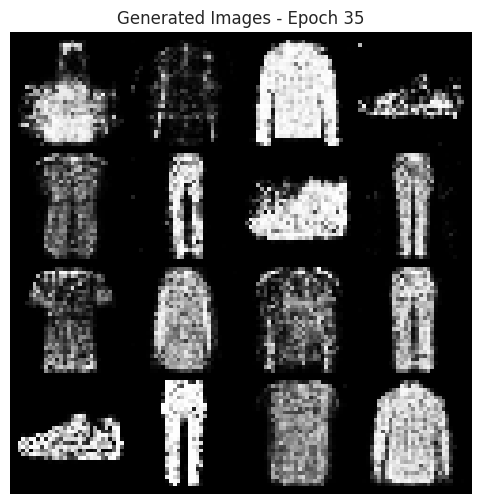

Epoch [36/50], D_Loss: 1.1813, G_Loss: 1.0908
Epoch [37/50], D_Loss: 1.1834, G_Loss: 1.0872
Epoch [38/50], D_Loss: 1.1832, G_Loss: 1.0934
Epoch [39/50], D_Loss: 1.1918, G_Loss: 1.0738
Epoch [40/50], D_Loss: 1.1922, G_Loss: 1.0726


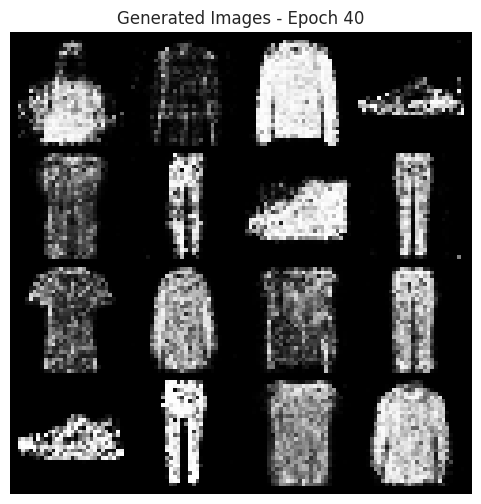

Epoch [41/50], D_Loss: 1.1840, G_Loss: 1.0819
Epoch [42/50], D_Loss: 1.1899, G_Loss: 1.0753
Epoch [43/50], D_Loss: 1.1900, G_Loss: 1.0777
Epoch [44/50], D_Loss: 1.1884, G_Loss: 1.0791
Epoch [45/50], D_Loss: 1.1914, G_Loss: 1.0688


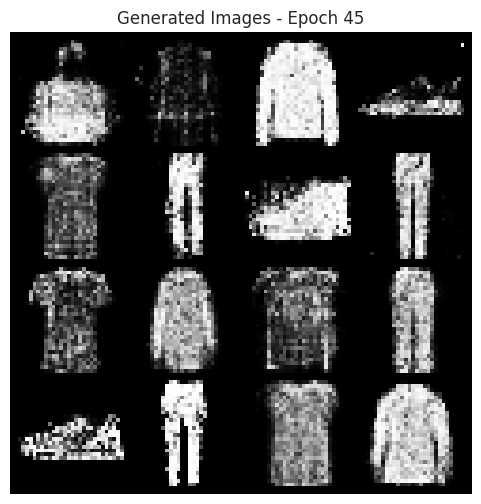

Epoch [46/50], D_Loss: 1.1934, G_Loss: 1.0664
Epoch [47/50], D_Loss: 1.1932, G_Loss: 1.0677
Epoch [48/50], D_Loss: 1.2027, G_Loss: 1.0536
Epoch [49/50], D_Loss: 1.1963, G_Loss: 1.0578
Epoch [50/50], D_Loss: 1.1965, G_Loss: 1.0558


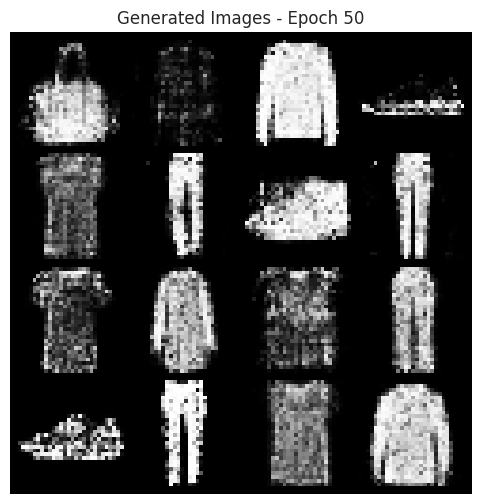

In [35]:
G_losses = []
D_losses = []
fixed_noise_for_sampling = torch.randn(16, latent_dim).to(device)

for epoch in range(num_epochs):
    epoch_D_loss = 0.0
    epoch_G_loss = 0.0
    num_batches_gan = 0

    for i, (real_imgs_batch, _) in enumerate(train_loader): # Labels not needed for GAN training
        current_batch_size = real_imgs_batch.size(0)
        real_imgs_batch = real_imgs_batch.to(device)
        
        # Create labels for real (1) and fake (0) images
        real_labels = torch.ones(current_batch_size, 1, device=device, dtype=torch.float32)
        fake_labels = torch.zeros(current_batch_size, 1, device=device, dtype=torch.float32)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Loss for real images
        real_imgs_flat = real_imgs_batch.view(current_batch_size, -1)
        d_output_real_logits = discriminator(real_imgs_flat)
        d_loss_real = adversarial_loss(d_output_real_logits, real_labels)
        
        # Loss for fake images
        z_noise = torch.randn(current_batch_size, latent_dim, device=device)
        fake_imgs_batch = generator(z_noise) # Output shape [batch, C, H, W]
        
        # Detach fake_imgs_batch so G's gradients are not computed during D's update
        d_output_fake_logits = discriminator(fake_imgs_batch.detach().view(current_batch_size, -1))
        d_loss_fake = adversarial_loss(d_output_fake_logits, fake_labels)
        
        # Total discriminator loss
        d_loss_total = d_loss_real + d_loss_fake
        d_loss_total.backward()
        optimizer_D.step()
        
        epoch_D_loss += d_loss_total.item()

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        d_output_on_fake_for_G_logits = discriminator(fake_imgs_batch.view(current_batch_size, -1)) 
        g_loss = adversarial_loss(d_output_on_fake_for_G_logits, real_labels) # G tries to fool D
        
        g_loss.backward()
        optimizer_G.step()

        epoch_G_loss += g_loss.item()
        num_batches_gan +=1

    avg_epoch_D_loss = epoch_D_loss / num_batches_gan
    avg_epoch_G_loss = epoch_G_loss / num_batches_gan
    D_losses.append(avg_epoch_D_loss)
    G_losses.append(avg_epoch_G_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], D_Loss: {avg_epoch_D_loss:.4f}, G_Loss: {avg_epoch_G_loss:.4f}")

    if (epoch + 1) % 5 == 0 or epoch == num_epochs - 1:
        generator.eval() # Set generator to eval mode for sampling
        with torch.no_grad():
            sampled_imgs = generator(fixed_noise_for_sampling)
        imshow_gan(sampled_imgs, title=f"Generated Images - Epoch {epoch+1}", num_images=16)
        generator.train() # Set back to train mode

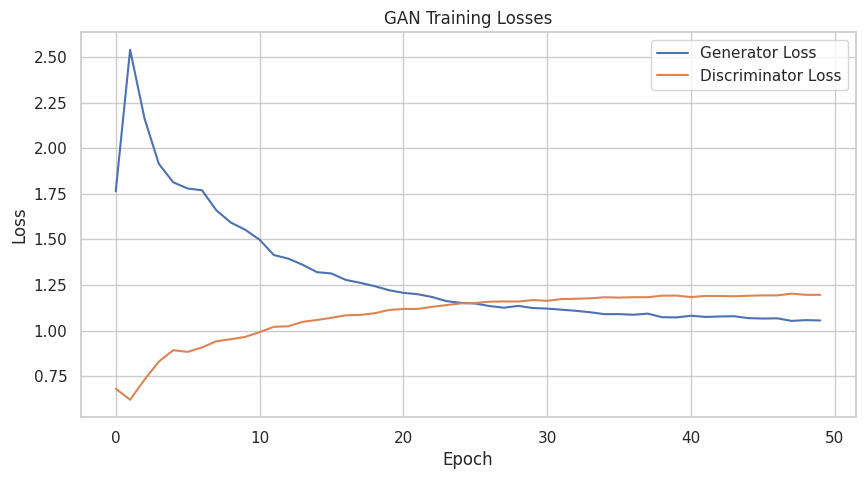

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(G_losses, label='Generator Loss')
plt.plot(D_losses, label='Discriminator Loss')
plt.title("GAN Training Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

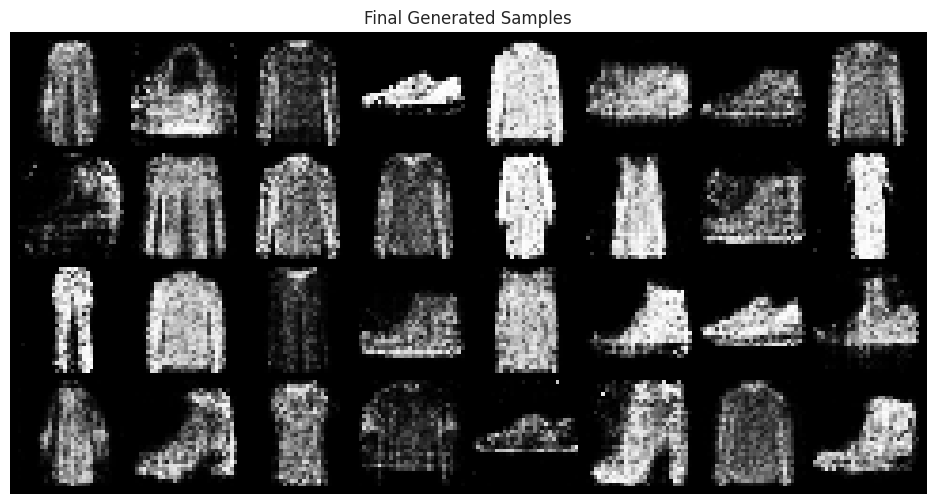

In [38]:
generator.eval()
with torch.no_grad():
    final_noise = torch.randn(64, latent_dim).to(device) 
    final_generated_images = generator(final_noise)
imshow_gan(final_generated_images, title="Final Generated Samples", num_images=32, nrow=8)

#### Common GAN Challenges
- Mode Collapse: Generator produces very limited variety of samples.
- Non-Convergence/Oscillations: D and G losses may not smoothly converge; they might oscillate.
- Vanishing Gradients for G: If D gets too good too quickly, G struggles to learn.
- Hyperparameter Sensitivity: GANs can be very sensitive to learning rates, batch sizes, network architecture.
- Evaluation: Quantitatively evaluating GANs is challenging (FID, IS scores are common).

**Tips**:
- Use LeakyReLU instead of ReLU in Discriminator.
- Use Tanh for Generator's output if data is normalized to [-1,1], Sigmoid if [0,1].
- Normalize input data (e.g., to [-1,1]).
- Use Adam optimizer with specific betas (e.g., beta1=0.5).
- Label smoothing for Discriminator targets (e.g., real labels 0.9 instead of 1.0).
- Careful architectural choices (e.g., DCGAN for images).